In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#**0. Thư viện**

##Cài đặt 

In [ ]:
# !pip3 numpy torc sklearn matplotlib pandas

##Import

In [ ]:
# Add Module Path - To Import Custom Modules
# Modules Path
ModulePath = "/content/drive/My Drive/Study/KLTN/Google Colab/0.0 Python Modules/"

import sys
sys.path.append(ModulePath)

In [ ]:
import numpy as np
import pandas as pd
import torch as th
from torch.autograd import Variable as V
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

# Libs for Keras
from keras.models import load_model


# Own Custom Module to import models and constants
from models import *
from constants import *

import matplotlib.pyplot as plt
import math
import os
from datetime import date
import timeit

Using TensorFlow backend.


#**1. Chuẩn bị**

##Paths

In [ ]:
# Base Path
base_path = "/content/drive/My Drive/Study/KLTN/"
Dataset_Path = base_path + "Dataset/NSL-KDD Processed/Final - For Using/"
SavedModelPath = base_path + "Saved Model/"

# Dataset Path
Trainsets_Path = Dataset_Path + 'Trainset/'
g_trainset_path = Trainsets_Path + "GAN-G.csv"
d_trainset_path = Trainsets_Path + "GAN-D.csv"
testset_path = Dataset_Path + "Testset/" + "KDDTest+.csv"


# GAN Saved Models Paths
GAN_Model_Path = SavedModelPath + 'GANModel/'

# IDS Pytorch Saved Models Paths
IDS_Model_Path = SavedModelPath + 'IDSModel/'

##Global Variables

In [ ]:
# Global Variables
N_FEATURES = 41
# IDS
IDS_INPUT_DIM = N_FEATURES
IDS_OUTPUT_DIM = 2
# ATTACK_CATEGORIES = ['DOS', 'U2R_AND_R2L']

POS_FUNCTIONAL_FEATURES = {'DOS': DOS_FEATURES, 'U2R_AND_R2L': U2R_AND_R2L_FEATURES}
POS_NONFUNCTIONAL_FEATURES = {}
for attack_category, pos_functional_feature in POS_FUNCTIONAL_FEATURES.items():
    pos_nonfunctional_feature = []
    for i in range(N_FEATURES):
        if i not in pos_functional_feature:
            pos_nonfunctional_feature.append(i)
    POS_NONFUNCTIONAL_FEATURES[attack_category] = pos_nonfunctional_feature

IDS_MODELS = {'MLP': MLP, 'CNN': None, 'RNN': None}

In [ ]:
print('Position of Functional Features\n  ', POS_FUNCTIONAL_FEATURES)
print('Position of Functional Features:\n  ', POS_NONFUNCTIONAL_FEATURES)

Position of Functional Features
   {'DOS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 28, 29, 30], 'U2R_AND_R2L': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]}
Position of Functional Features:
   {'DOS': [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], 'U2R_AND_R2L': [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]}


# **2. Định nghĩa Model**

##Models

In [ ]:
# Load from model.py module

##Functions

### Processing Data Functions

In [ ]:
# Processing Data Functions
# create_batch2 - Hàm tạo Batch
def create_batch2(x,batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    batch_x = [x[batch_size * i : (i+1)*batch_size,:] for i in range(len(x)//batch_size)]
    return np.array(batch_x)
    
# preprocess_malicious_data - Hàm tiền xử lý dữ liệu tấn công
def preprocess_malicious_data(dataset, attack_category):
    if attack_category != 'DOS' and attack_category != 'U2R_AND_R2L':
      raise ValueError("Preprocess Data Fail: Invalid Attack Category")
    attack_data = dataset[dataset['class'] == attack_category]
    del attack_data["class"]
    return np.array(attack_data)

### IDS Functions

In [ ]:
# IDS Functions
# get_keras_ids_path - Get path for Keras IDS Models
def get_keras_ids_path(model_name, attack_category, created_date):
    if attack_category != 'DOS' and attack_category != 'U2R_AND_R2L':
        raise ValueError("Preprocess Data Fail: Invalid Attack Category")

    ids_path = str(f"{IDS_Model_Path}{attack_category}/Deep_Learning/created_date_{created_date}_{model_name}.h5")

    if not os.path.exists(ids_path):
        raise ValueError(f"Invalid path: {ids_path}\nNot exist file!")
    return ids_path

# load_keras_ids_model - Load Keras IDS Models
def load_keras_ids_model(model_name, attack_category, created_date):
    ids_model_path = get_keras_ids_path(model_name, attack_category, created_date)
    ids_model = load_model(ids_model_path)
    print(f"{4*' '}Loaded IDS Model From: {ids_model_path}")
    return ids_model

### GAN Functions

In [ ]:
# GAN Functions
# init_generator - Khoi tao model GAN-G
def init_generator(input_dim, output_dim, adversarial_attack_type = 1):
    if adversarial_attack_type == 1:
        generator = Generator_A1(input_dim, output_dim)
    elif adversarial_attack_type == 2:
        generator = Generator_A2(input_dim, output_dim)
    elif adversarial_attack_type == 3:
        '''
            adversarial_attack_type 3: G-input is nonfunctional feature, G-out is adversarial nonfuncitonal feature.
            --> input_dim = output_dim = len(nonfunctional_features)
        ''' 
        generator = Generator_A2(output_dim, output_dim)
    elif adversarial_attack_type == 4:
        '''
            adversarial_attack_type 4: G-input in random noise nf-dim (num. of nonfunctional features)
            --> input_dim = output_dim = len(nonfunctional_features)
        '''
        generator = Generator_A1(output_dim, output_dim)
    else:
        raise ValueError("Init GAN - Generator: Invalid Adversarial Attack Type")
    return generator

# gen_adversarial_attack - Tao luu luong tan cong doi khang
def gen_adversarial_attack(generator, noise_dim, raw_attack, attack_category, adversarial_attack_type = 1):
    if adversarial_attack_type == 1 or adversarial_attack_type == 4:
        adversarial_attack = generator(noise_dim, raw_attack, attack_category, POS_NONFUNCTIONAL_FEATURES)
    elif adversarial_attack_type == 2:
        batch_size = len(raw_attack)
        noise = V(th.Tensor(np.random.uniform(0,1,(batch_size, noise_dim))))
        generator_out = generator(noise)
        adversarial_attack = gen_adversarial_attack_a2(generator_out, raw_attack, attack_category, POS_NONFUNCTIONAL_FEATURES)
    elif  adversarial_attack_type == 3:
        pos_nonfunctional_feature = POS_NONFUNCTIONAL_FEATURES[attack_category]
        # get nonfunctional features val
        nonfunctional_feature = raw_attack[:, pos_nonfunctional_feature]
        generator_out = generator(nonfunctional_feature)
        adversarial_attack = gen_adversarial_attack_a2(generator_out, raw_attack, attack_category, POS_NONFUNCTIONAL_FEATURES)
    else:
        raise ValueError("Init GAN - Generator: Invalid Adversarial Attack Type")
    return adversarial_attack

# train_generator - Train Generator
def train_generator(generator, discriminator, optimizer_G, noise_dim, attack_traffic, attack_category, adversarial_attack_type):
    for p in discriminator.parameters():  
        p.requires_grad = False
    optimizer_G.zero_grad()        
    # GAN-G Generate Adversarial Attack
    adversarial_attack = gen_adversarial_attack(generator, noise_dim, attack_traffic, attack_category, adversarial_attack_type)
    # GAN-D predict, GAN-G update parameter
    D_pred = discriminator(adversarial_attack)
    g_loss = -th.mean(D_pred)
    g_loss.backward()
    optimizer_G.step()
    return g_loss

# train_discriminator - Train Discriminator
def train_discriminator(discriminator, ids_model, generator, critic_iters, clamp, optimizer_D, normal_b, noise_dim, attack_traffic, attack_category, adversarial_attack_type):
    run_d_loss = 0
    cnt = 0
    for p in discriminator.parameters(): 
        p.requires_grad = True
    for c in range(critic_iters):
        optimizer_D.zero_grad()
        for p in discriminator.parameters():
            p.data.clamp_(-clamp, clamp)
        # GAN-G Generate Adversarial Attack
        adversarial_attack = gen_adversarial_attack(generator, noise_dim, attack_traffic, attack_category, adversarial_attack_type)
        # Make data to feed IDS
        ids_input = th.cat((adversarial_attack,normal_b))
        l = list(range(len(ids_input)))
        np.random.shuffle(l)
        ids_input = V(th.Tensor(ids_input[l]))
        ids_input_keras = ids_input.reshape(ids_input.shape[0], N_FEATURES, 1)      # Keras Format
        # IDS Predict
        ids_pred = V(th.Tensor(ids_model.predict(ids_input_keras)))
        ids_pred_label = th.argmax(nn.Sigmoid()(ids_pred),dim = 1).detach().numpy()
        pred_normal = ids_input.numpy()[ids_pred_label==0]
        pred_attack = ids_input.numpy()[ids_pred_label==1]
        if len(pred_attack) == 0:
            cnt += 1
            break
        # Make GAN-D input
        D_noraml = discriminator(V(th.Tensor(pred_normal)))
        D_attack= discriminator(V(th.Tensor(pred_attack)))
        # Loss and Update Parameter
        loss_normal = th.mean(D_noraml)
        loss_attack = th.mean(D_attack)
        if GAN_variant == 'WGAN':
            d_loss = loss_attack - loss_normal #+ LAMBDA * gradient_penalty
        elif GAN_variant == 'WGAN-GP':
            gradient_penalty = compute_gradient_penalty(discriminator, normal_b.data, adversarial_attack.data)
            d_loss = loss_attack - loss_normal + LAMBDA * gradient_penalty
        d_loss.backward()
        optimizer_D.step()
        run_d_loss += d_loss.item()
    return run_d_loss, cnt

# compute_gradient_penalty - Compute Gradient Penalty
def compute_gradient_penalty(D, normal_t, attack_t):
    alpha = th.Tensor(np.random.random((normal_t.shape[0], 1)))
    between_n_a = (alpha * normal_t + ((1 - alpha) * attack_t)).requires_grad_(True)
    d_between_n_a = D(between_n_a)
    adv = V(th.Tensor(normal_t.shape[0], 1).fill_(1.0), requires_grad=False)

    gradients = autograd.grad(
        outputs=d_between_n_a,
        inputs=between_n_a,
        grad_outputs=adv,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

### Generate Adversarial Attack Functions

In [ ]:
# cal_dr - Tinh DR
def cal_dr(ids_model, normal, raw_attack, adversarial_attack):
    # Make data to feed IDS contain: Attack & Normal
    o_ids_input = th.cat((raw_attack, normal))
    a_ids_input = th.cat((adversarial_attack,normal))
    # Shuffle Input
    l = list(range(len(a_ids_input)))
    np.random.shuffle(l)
    o_ids_input = o_ids_input[l]
    o_ids_input = o_ids_input.reshape(o_ids_input.shape[0], N_FEATURES, 1)      # Keras Format
    a_ids_input = a_ids_input[l].detach()
    a_ids_input = a_ids_input.reshape(a_ids_input.shape[0], N_FEATURES, 1)      # Keras Format
    # IDS Predict Label
    o_ids_pred = th.Tensor(ids_model.predict(o_ids_input))
    o_pred_label = th.argmax(nn.Sigmoid()(o_ids_pred),dim = 1).detach().numpy()
    a_ids_pred = th.Tensor(ids_model.predict(a_ids_input))
    a_pred_label = th.argmax(nn.Sigmoid()(a_ids_pred),dim = 1).detach().numpy()
    # True Label
    ids_true_label = np.r_[np.ones(BATCH_SIZE),np.zeros(BATCH_SIZE)][l]
    # Calc DR
    tn1, fn1, fp1, tp1 = confusion_matrix(ids_true_label,o_pred_label).ravel()
    tn2, fn2, fp2, tp2 = confusion_matrix(ids_true_label,a_pred_label).ravel()
    origin_dr = tp1/(tp1 + fp1)
    adversarial_dr = tp2/(tp2 + fp2)
    return origin_dr, adversarial_dr

# **3. Run Model**

In [ ]:
IDS_Model_Created_Auto = {'CNN': '2020-07-17',
                          'RNN': 'Unknown'
                          }

In [ ]:
#@title **CONSTS**
ids_dl_model_name = "CNN" #@param ["CNN", "RNN"]
ids_created_date = 'Auto' #@param ['Auto', '2020-07-17']
if ids_created_date == 'Auto':
    ids_created_date = IDS_Model_Created_Auto[ids_dl_model_name]
    print(f"IDS: {ids_dl_model_name} - created on: \t{ids_created_date}")
GAN_variant = 'WGAN' #@param ['WGAN', 'WGANGP']
MAX_EPOCH = 100 #@param [100, 10, 2, 1] {type:"raw"}
ATTACK_CATEGORIES = 'ALL' #@param ['ALL', 'DOS', 'U2R_AND_R2L']
if ATTACK_CATEGORIES == 'ALL':
    ATTACK_CATEGORIES = ['DOS', 'U2R_AND_R2L']
else:
    ATTACK_CATEGORIES = [ATTACK_CATEGORIES]
print(f"ATTACK_CATEGORIES: \t\t{ATTACK_CATEGORIES}")

ADVERSARIAL_ATTACK_TYPES = 3 #@param [0, 1, 2, 3, 4] {type:"raw"}
if ADVERSARIAL_ATTACK_TYPES == 0:
    ADVERSARIAL_ATTACK_TYPES = [1, 2, 3, 4]
else:
    ADVERSARIAL_ATTACK_TYPES = [ADVERSARIAL_ATTACK_TYPES]
print(f"ADVERSARIAL_ATTACK_TYPES: \t{ADVERSARIAL_ATTACK_TYPES}")

NOISE_DIM = 9 #@param[9, 41] {type:"raw"}

IDS: CNN - created on: 	2020-07-17
ATTACK_CATEGORIES: 		['DOS', 'U2R_AND_R2L']
ADVERSARIAL_ATTACK_TYPES: 	[3]


##**3.1 Run IDSGAN**

In [ ]:
# Hyber Parameters
BATCH_SIZE = 64
learning_rate = 0.0001
LAMBDA = 10
CLAMP = 0.01
CRITIC_ITERS = 5          # For WGAN and WGAN-GP, number of critic iters per gen iter

# GAN-D
D_INPUT_DIM = N_FEATURES
D_OUTPUT_DIM = 1
discriminator = Discriminator(D_INPUT_DIM,D_OUTPUT_DIM)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=learning_rate)

In [ ]:
# Get today to set created time for GAN models
today = str(date.today())

## Prepare Dataset
g_train_data = pd.read_csv(g_trainset_path)
d_train_data = pd.read_csv(d_trainset_path)

# All normal record in train_data
del d_train_data["class"]
normal = np.array(d_train_data)

print("Amout of Generator Trainset:", g_train_data.shape[0])
print("Amout of Discriminator Trainset:", d_train_data.shape[0])

Amout of Generator Trainset: 23488
Amout of Discriminator Trainset: 33672


======================================== TRAINING GAN ========================================
 IDS Model: CNN
********************************************************************************
  Adversarial Attack Type : 3
--------------------------------------------------------------------------------
    Attack Category: DOS
    Loaded IDS Model From: /content/drive/My Drive/Study/KLTN/Saved Model/IDSModel/DOS/Deep_Learning/created_date_2020-07-17_CNN.h5
    nf              : 24 (num. of nonfunctional features)
    GAN-G NOISE DIM : 24
    GAN-G INPUT DIM : 24
    GAN-G OUTPUT DIM: 24
==>IDSGAN start training
    Folder for saving GAN Models : /content/drive/My Drive/Study/KLTN/Saved Model/GANModel/Deep_Learning/CNN/DOS/3/
     Epoch          G-Loss          D-Loss         O-DR(%)         A-DR(%)      Runtime(s)
         1           -4.27           -2.51           98.60           29.78           51.63
      -> GAN-G - DOS - A3 Saved: time_created_2020-07-22_GAN_G_1epoch.pth
         2

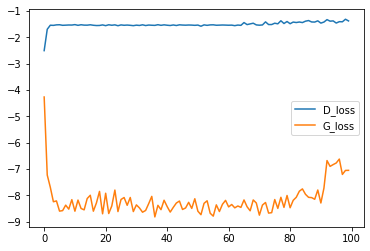

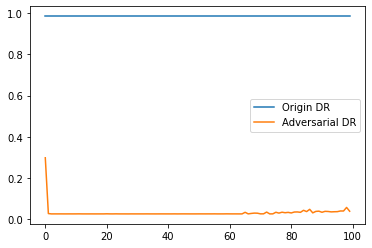

      -> GAN-D - DOS - A3Saved: time_created_2020-07-22_GAN_D_100epoch.pth
--------------------------------------------------------------------------------
    Attack Category: U2R_AND_R2L
    Loaded IDS Model From: /content/drive/My Drive/Study/KLTN/Saved Model/IDSModel/U2R_AND_R2L/Deep_Learning/created_date_2020-07-17_CNN.h5
    nf              : 18 (num. of nonfunctional features)
    GAN-G NOISE DIM : 18
    GAN-G INPUT DIM : 18
    GAN-G OUTPUT DIM: 18
==>IDSGAN start training
    Folder for saving GAN Models : /content/drive/My Drive/Study/KLTN/Saved Model/GANModel/Deep_Learning/CNN/U2R_AND_R2L/3/
     Epoch          G-Loss          D-Loss         O-DR(%)         A-DR(%)      Runtime(s)
         1           -3.13           -0.33           35.56            0.29           30.09
      -> GAN-G - U2R_AND_R2L - A3 Saved: time_created_2020-07-22_GAN_G_1epoch.pth
         2           -0.18           -0.37           35.56            3.01           32.46
         3           -3.01        

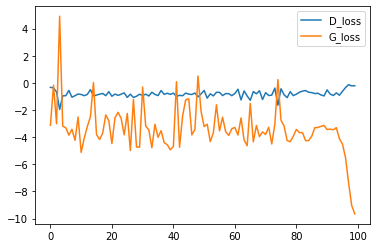

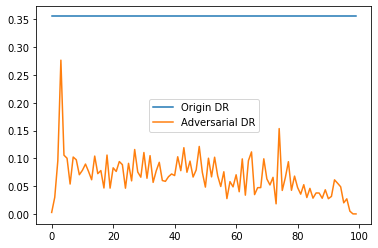

      -> GAN-D - U2R_AND_R2L - A3Saved: time_created_2020-07-22_GAN_D_100epoch.pth


In [ ]:
print(f"{40*'='} TRAINING GAN {40*'='}")
print(f"{80*'='}\n IDS Model: {ids_dl_model_name}")

for adversarial_attack_type in ADVERSARIAL_ATTACK_TYPES:
    print(f"{80*'*'}\n  Adversarial Attack Type : {adversarial_attack_type}")
    for attack_category in ATTACK_CATEGORIES:
        print(f"{80*'-'}\n    Attack Category: {attack_category}")
        total_time_start = timeit.default_timer()

        # Load Keras IDS Model
        ids_model = load_keras_ids_model(ids_dl_model_name, attack_category, ids_created_date)
        # Init GAN-G model
        G_OUTPUT_DIM = len(POS_NONFUNCTIONAL_FEATURES[attack_category])     # Generator output is number of nonfunctional feature
        print(f"    nf              : {G_OUTPUT_DIM} (num. of nonfunctional features)")
        if adversarial_attack_type == 4 or adversarial_attack_type == 3:
            NOISE_DIM = G_OUTPUT_DIM                                        # Adversarial Attack Type 3,4: Noise dim = nonfunctional feature
        G_INPUT_DIM = NOISE_DIM                                             # G_INPUT_DIM = NOISE_DIM
        print(f"    GAN-G NOISE DIM : {NOISE_DIM}")
        print(f"    GAN-G INPUT DIM : {G_INPUT_DIM}")
        print(f"    GAN-G OUTPUT DIM: {G_OUTPUT_DIM}")
        
        G_INPUT_DIM = NOISE_DIM                                             # Generator input dimension is dimention of noise
        generator = init_generator(G_INPUT_DIM,G_OUTPUT_DIM, adversarial_attack_type)
        optimizer_G = optim.RMSprop(generator.parameters(), lr=learning_rate)
        # Load Raw Attack Dataset
        raw_attack = preprocess_malicious_data(g_train_data, attack_category)
        # Prepare Save Folder
        GAN_4IDS_Model_Path = str(f"{GAN_Model_Path}Deep_Learning/{ids_dl_model_name}/")
        if not os.path.exists(GAN_4IDS_Model_Path):
                os.makedirs(GAN_4IDS_Model_Path)
        GAN_Save_Path = str(f"{GAN_4IDS_Model_Path}{attack_category}/{adversarial_attack_type}/")
        if not os.path.exists(GAN_Save_Path):
            os.makedirs(GAN_Save_Path)
        
        # Create batch of attack traffic
        batch_attack = create_batch2(raw_attack,BATCH_SIZE)
        # Declare Loss, DR List and Train GAN-G, GAN-D
        d_losses,g_losses = [],[]
        o_dr, a_dr = [],[]
        generator.train()
        discriminator.train()

        # Start Training
        print(f"==>IDSGAN start training")
        print(f"{4*' '}Folder for saving GAN Models : {GAN_Save_Path}")
        labels = ['Epoch', 'G-Loss', 'D-Loss', 'O-DR(%)', 'A-DR(%)', 'Runtime(s)']
        print("{: >10} {: >15} {: >15} {: >15} {: >15} {: >15}".format(*labels))
        for epoch in range(MAX_EPOCH):
            batch_normal = create_batch2(normal,BATCH_SIZE)
            epoch_time_start = timeit.default_timer()
            cnt = 0
            run_g_loss = 0.
            run_d_loss = 0.
            epoch_o_drs, epoch_a_drs = [], []

            for idx, bn in enumerate(batch_normal):
                normal_b = th.Tensor(bn.astype("float64"))
                attack_traffic  = V(th.Tensor(batch_attack[idx % len(batch_attack)]))
                #  Train Generator
                g_loss = train_generator(generator, discriminator, optimizer_G, NOISE_DIM, attack_traffic, attack_category, adversarial_attack_type)
                run_g_loss += g_loss.item()

                # Train Discriminator
                d_loss, current_cnt = train_discriminator(discriminator, ids_model, generator, CRITIC_ITERS, CLAMP, optimizer_D, normal_b, NOISE_DIM, attack_traffic, attack_category, adversarial_attack_type)
                run_d_loss += d_loss
                cnt += current_cnt
                
                # CALC Epoch DR
                adversarial_attack = gen_adversarial_attack(generator, NOISE_DIM, attack_traffic, attack_category, adversarial_attack_type)
                origin_dr, adversarial_dr = cal_dr(ids_model, normal_b, attack_traffic, adversarial_attack)
                epoch_o_drs.append(origin_dr)
                epoch_a_drs.append(adversarial_dr)

            if cnt >= (len(normal)/BATCH_SIZE):
                print("Not exist predicted attack traffic")
                break
            d_losses.append(run_d_loss/CRITIC_ITERS)
            g_losses.append(run_g_loss)
            epoch_o_dr = np.mean(epoch_o_drs)
            epoch_a_dr = np.mean(epoch_a_drs)
            o_dr.append(epoch_o_dr)
            a_dr.append(epoch_a_dr)
            
            runtime = timeit.default_timer() - epoch_time_start
            print_vals = [(epoch + 1), run_g_loss, (run_d_loss/CRITIC_ITERS), (epoch_o_dr*100), (epoch_a_dr*100), runtime]
            print_string = []
            for val in print_vals:
                if isinstance(val, float):
                    print_string.append(str(f"{val:.2f}"))
                else:
                    print_string.append(str(val))
            print("{: >10} {: >15} {: >15} {: >15} {: >15} {: >15}".format(*print_string))
            # Save Adversarial Dataset each 10 epoch
            if (epoch == 0 or (epoch + 1) % 10 == 0):
                model_g_save_name = f"time_created_{today}_GAN_G_{epoch+1}epoch.pth"
                path = GAN_Save_Path + model_g_save_name
                th.save(generator.state_dict(), path)
                print(f"{6*' '}-> GAN-G - {attack_category} - A{adversarial_attack_type} Saved: {model_g_save_name}")
        total_runtime = timeit.default_timer() - total_time_start
        print(f"Training Runtime: {total_runtime:.2f}")
        print("IDSGAN finish training!")
        
        # Show Graph
        # Loss-Graph
        plt.plot(d_losses,label = "D_loss")
        plt.plot(g_losses, label = "G_loss")
        plt.legend()
        plt.show()
        # DR-Graph
        plt.plot(o_dr,label = "Origin DR")
        plt.plot(a_dr, label = "Adversarial DR")
        plt.legend()
        plt.show()

        # Save Model
        model_d_save_name = f"time_created_{today}_GAN_D_{MAX_EPOCH}epoch.pth"
        path = GAN_Save_Path + model_d_save_name
        th.save(discriminator.state_dict(), path)
        print(f"{6*' '}-> GAN-D - {attack_category} - A{adversarial_attack_type}Saved: {model_d_save_name}")

## **3.2 Run Generate Adversarial Traffic**

In [ ]:
# Hyber Parameters
BATCH_SIZE = 256 # Batch size

In [ ]:
gan_model_time_created = str(date.today())

# Load Testset
testset = pd.read_csv(testset_path)
print(f"Amount of KDDTest+: \t\t{len(testset)}")
# test_normal
test_normal = np.array(testset[testset["class"] == 'Normal'])[:,:-1]
# Create batch of normal traffic
test_batch_normal = create_batch2(test_normal,BATCH_SIZE).astype('float64')
print(f"Amount of Normal:\t\t{len(test_normal)} ({len(test_batch_normal)} batchs - {BATCH_SIZE} records/batch)")

Amount of KDDTest+: 		20123
Amount of Normal:		9711 (37 batchs - 256 records/batch)


In [ ]:
# Adversarial Traffic Evaluating
print(f"{40*'='} ADVERSARIAL TRAFFIC EVALUATING {40*'='}")
print(f"{80*'='}\n IDS Model: {ids_dl_model_name}")

for adversarial_attack_type in ADVERSARIAL_ATTACK_TYPES:
    print(f"{80*'*'}\n Adversarial Attack Type : {adversarial_attack_type}")
    for attack_category in ATTACK_CATEGORIES:
        print(f"{80*'-'}\n - Attack Category: {attack_category}")
        
        # Load PyTorch IDS Model
        ids_model = load_keras_ids_model(ids_dl_model_name, attack_category, ids_created_date)
        # Init GAN-G model
        G_OUTPUT_DIM = len(POS_NONFUNCTIONAL_FEATURES[attack_category])     # Generator output is number of nonfunctional feature
        print(f"    nf              : {G_OUTPUT_DIM} (num. of nonfunctional features)")
        if adversarial_attack_type == 4 or adversarial_attack_type == 3:
            NOISE_DIM = G_OUTPUT_DIM                                        # Adversarial Attack Type 3,4: Noise dim = nonfunctional feature
        G_INPUT_DIM = NOISE_DIM                                             # G_INPUT_DIM = NOISE_DIM
        print(f"    GAN-G NOISE DIM : {NOISE_DIM}")
        print(f"    GAN-G INPUT DIM : {G_INPUT_DIM}")
        print(f"    GAN-G OUTPUT DIM: {G_OUTPUT_DIM}")
        generator = init_generator(G_INPUT_DIM,G_OUTPUT_DIM, adversarial_attack_type)
        # Load Attack Dataset
        test_raw_attack = preprocess_malicious_data(testset, attack_category)
        # Create batch of attack traffic
        batch_attack = create_batch2(test_raw_attack, BATCH_SIZE)
        n_batch_attack = len(batch_attack)
        print(f"{4*' '}Amout of {attack_category}:\t{len(test_raw_attack)} ({n_batch_attack} batchs - {BATCH_SIZE} records/batch)")
        
        # Calc DR through each epoch
        gan_g_folder_path = str(f"{GAN_Model_Path}Deep_Learning/{ids_dl_model_name}/{attack_category}/{adversarial_attack_type}/")
        print(f"{4*' '}GAN Models Folder: {gan_g_folder_path}")
        for epoch in range(0, MAX_EPOCH + 1, 10):
            # Load GAN-G Model
            model_g_save_name = f"time_created_{gan_model_time_created}_GAN_G_{1 if epoch == 0 else epoch}epoch.pth"
            gan_g_model_path = gan_g_folder_path + model_g_save_name
            param = th.load(gan_g_model_path,map_location=lambda x,y:x)
            generator.load_state_dict(param)

            generator.eval()

            o_dr,a_dr =[],[]
            with th.no_grad():
                for idx, bn in enumerate(test_batch_normal):
                    normal_b = th.Tensor(bn)
                    attack_b = th.Tensor(batch_attack[idx % n_batch_attack])
                    # Generate Adversarial Traffic
                    adversarial_attack_b = gen_adversarial_attack(generator, NOISE_DIM, attack_b, attack_category, adversarial_attack_type)

                    # Calc DR
                    origin_dr, adversarial_dr = cal_dr(ids_model, normal_b, attack_b, adversarial_attack_b)
                    o_dr.append(origin_dr)
                    a_dr.append(adversarial_dr)
            eir = 1 - (np.mean(a_dr)/np.mean(o_dr))
            print(f"\t {epoch:3d} epochs:\tOrigin DR : {np.mean(o_dr)*100:.2f}% \t Adversarial DR : {np.mean(a_dr)*100:.2f}% \t EIR : {eir*100:.2f}%")

======================================== ADVERSARIAL TRAFFIC EVALUATING ========================================
 IDS Model: CNN
********************************************************************************
 Adversarial Attack Type : 3
--------------------------------------------------------------------------------
 - Attack Category: DOS
    Loaded IDS Model From: /content/drive/My Drive/Study/KLTN/Saved Model/IDSModel/DOS/Deep_Learning/created_date_2020-07-17_CNN.h5
    nf              : 24 (num. of nonfunctional features)
    GAN-G NOISE DIM : 24
    GAN-G INPUT DIM : 24
    GAN-G OUTPUT DIM: 24
    Amout of DOS:	7460 (29 batchs - 256 records/batch)
    GAN Models Folder: /content/drive/My Drive/Study/KLTN/Saved Model/GANModel/Deep_Learning/CNN/DOS/3/
	   0 epochs:	Origin DR : 81.73% 	 Adversarial DR : 3.10% 	 EIR : 96.20%
	  10 epochs:	Origin DR : 81.73% 	 Adversarial DR : 1.17% 	 EIR : 98.57%
	  20 epochs:	Origin DR : 81.73% 	 Adversarial DR : 1.31% 	 EIR : 98.40%
	  30 epochs:

The Saved Model stored in [Google Drive - GAN Model](https://drive.google.com/drive/u/1/folders/1VNFW-k5SbR0eGsJ_np3U-W3Rcz_n4I8N)

The Result of Code stored in [Github - Thesis](https://github.com/thetinybug/thesis-IDSGAN)